In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd
from tqdm import tqdm
import torch
from PIL import Image

import sys
sys.path.append('../SRGAN/')
from srgan import Generator

sys.path.append('../')
from model_runner import ModelRunner
from image_helper import ImageHelper

# Display Video in Notebook

In [2]:
ipd.Video('./videos/raccoon-1080p.mp4', width=500)

Exploring the video metadata

In [3]:
cap = cv2.VideoCapture('./videos/raccoon-1080p.mp4')

In [4]:
print('total number of frames =', cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('frame rate =', cap.get(cv2.CAP_PROP_FPS))
print('frame size =', (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))


total number of frames = 1237.0
frame rate = 59.94005994005994
frame size = (1920.0, 1080.0)


In [5]:
cap.release()

# Pulling image from video

In [6]:
cap = cv2.VideoCapture('./videos/raccoon-1080p.mp4')
ret, img = cap.read()
print(f'Return value: {ret} with shape {img.shape}')

Return value: True with shape (1080, 1920, 3)


In [7]:
## Helper function for plotting opencv images in notebook
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

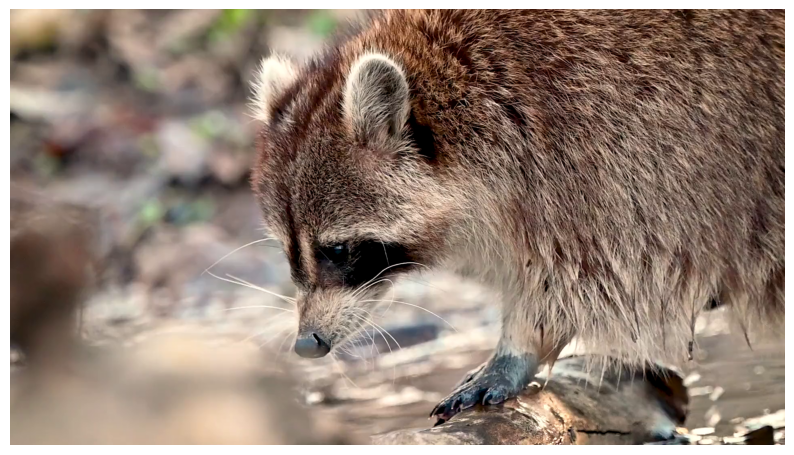

In [8]:
display_cv2_img(img)

In [9]:
cap.release()

# Apply model to frame

In [10]:
image_helper = ImageHelper()
model_runner = ModelRunner(device='cpu')

# Load SRGAN model
UPSCALE_FACTOR = 4
srgan = Generator(UPSCALE_FACTOR).to('cpu')
srgan.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG-150-epochs.pth',  map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
# Function to downsample an image using your image_helper.downsample_image function
def downsample_frame(frame):
    pil_frame = cv2_to_pil(frame)
    downsampled_frame = image_helper.downsample_image(pil_frame, 15)
    return pil_to_cv2(downsampled_frame)

## Helper function for converting opencv images to PIL images
def cv2_to_pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Function to convert PIL image (RGB) to OpenCV image (BGR)
def pil_to_cv2(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)


In [13]:
cap = cv2.VideoCapture('./videos/raccoon-1080p.mp4')
ret, img = cap.read()
pil_img = cv2_to_pil(img)

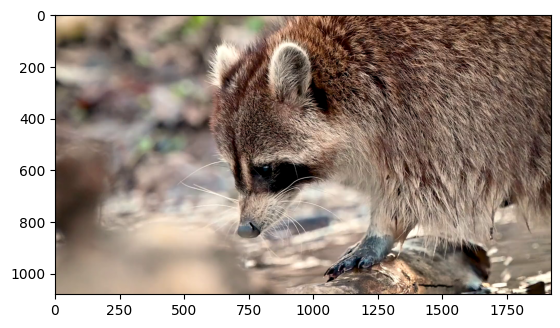

In [17]:
plt.imshow(pil_img)

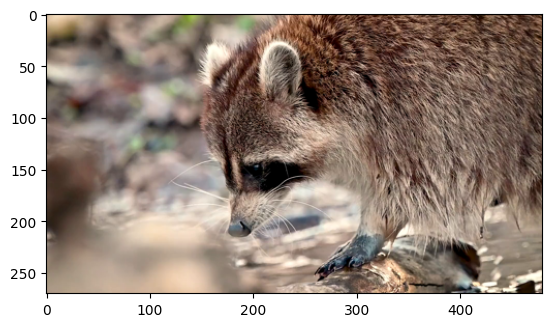

In [55]:
downsampled_img = image_helper.downsample_image(pil_img, 4)
plt.imshow(downsampled_img)

should_upsample MUST ONLY BE `TRUE` for SRCNN


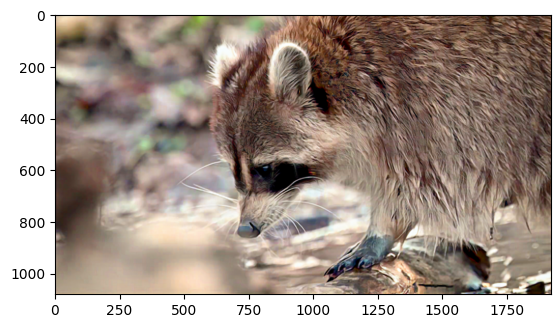

In [56]:
image_helper.apply_model_to_image_and_show(
    model=srgan.to('cpu'),
    image=downsampled_img,
    downsample_factor=1, # Aqui é pra ser 1 msm, porque nesse caso a imagem já está downsampled
    unsqueeze=True,
    should_upsample=False,
    device='cpu'
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


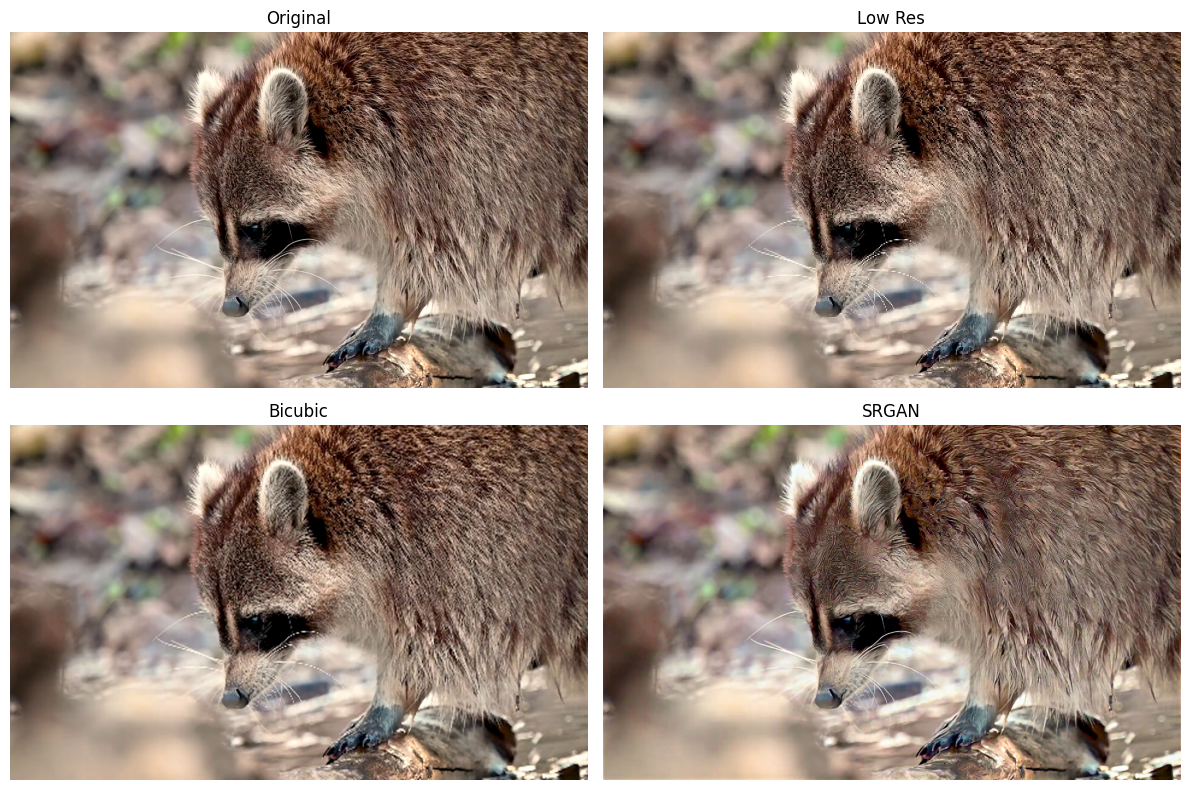

In [62]:
image_helper.show_tensors_custom_grid(
    tensors = [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(pil_img),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                pil_img, UPSCALE_FACTOR, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                pil_img, UPSCALE_FACTOR
            ),
        },
        {
            "label": "SRGAN",
            "tensor": image_helper.apply_model_to_image(
                srgan.to('cpu'),
                pil_img,
                downsample_factor=UPSCALE_FACTOR,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
    ],
    rows=2,
    cols=2
)

In [18]:
cap = cv2.VideoCapture('./videos/raccoon-1080p.mp4')
ret, img = cap.read()
pil_img = cv2_to_pil(img)

print(f'Return value: {ret} with shape {pil_img.size}')

Return value: True with shape (1920, 1080)


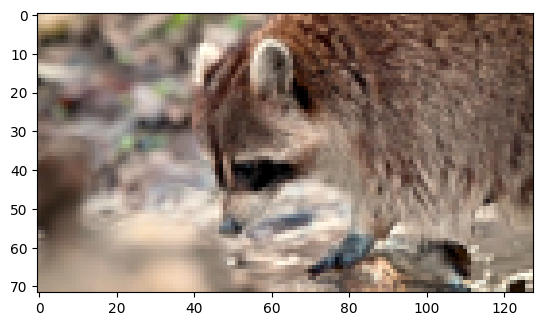

In [19]:
downsampled_img = image_helper.downsample_image(pil_img, 15)
plt.imshow(downsampled_img)

In [20]:
# iterate over each frame in the video and downsample them by 15 and save it to a new mp4 file

cap = cv2.VideoCapture('./videos/raccoon-1080p.mp4')
# Get video information (e.g., frame width, frame height, frames per second, etc.)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(5))

# Define the codec and create a VideoWriter object to save the downsampled frames
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
out = cv2.VideoWriter('./videos/downsampled_raccoon.mp4', fourcc, fps, (frame_width, frame_height))

# Loop through each frame in the video
while True:
    ret, frame = cap.read()
    
    if not ret:
        break  # Break the loop if we have reached the end of the video
    
    # Downsample the frame
    downsampled_frame = downsample_frame(frame)
    
    # Write the downsampled frame to the output video
    out.write(downsampled_frame)

# Release the video capture and output writer objects
cap.release()
out.release()

# Close any open windows
cv2.destroyAllWindows()

print("Video has been downsampled and saved.")


Video has been downsampled and saved.


In [22]:
ipd.Video('./videos/downsampled_raccoon.mp4', width=500)

In [26]:
cap = cv2.VideoCapture('./videos/downsampled_raccoon.mp4')
ret, img = cap.read()
print(f'Return value: {ret}')

Return value: False


In [33]:
VIDEO_CODEC = "mp4v"
# Get video information (e.g., frame width, frame height, frames per second, etc.)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(5))

print(f'frame width = {frame_width}, frame height = {frame_height}, fps = {fps}')

out = cv2.VideoWriter("./videos/out_test.mp4",
                cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                fps,
                (frame_width, frame_height))

cap = cv2.VideoCapture("./videos/raccoon-1080p.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for frame in tqdm(range(n_frames)):
    ret, img = cap.read()
    if ret == False:
        break
    # img = add_annotations(img, frame, video_labels)
    out.write(img)
out.release()
cap.release()

frame width = 0, frame height = 0, fps = 0
























100%|██████████| 1237/1237 [00:02<00:00, 535.33it/s]


In [23]:
import os

# Open the video capture
cap = cv2.VideoCapture('./videos/raccoon-1080p.mp4')

# Get video information (e.g., frame width, frame height, frames per second, etc.)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(5))

# Define the codec and create a VideoWriter object to save the downsampled frames
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Change the codec as needed
output_path = './videos/downsampled_raccoon-2.mp4'

# Create the directory if it doesn't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Loop through each frame in the video
while True:
    ret, frame = cap.read()
    
    if not ret:
        break  # Break the loop if we have reached the end of the video
    
    # Downsample the frame
    downsampled_frame = downsample_frame(frame)
    
    # Write the downsampled frame to the output video
    out.write(downsampled_frame)

# Release the video capture and output writer objects
cap.release()
out.release()

print("Video has been downsampled and saved.")

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Video has been downsampled and saved.


In [37]:
# image_helper.apply_model_to_image_and_show(
#     model=srgan,
#     image=pil_img,
#     downsample_factor=UPSCALE_FACTOR,
#     should_upsample=False,
#     unsqueeze=True
# )

should_upsample MUST ONLY BE `TRUE` for SRCNN


/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
